In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pdb
import wandb

import torch
import torch.nn.functional as F
from torch.nn import ReLU, Linear, Sequential, ModuleList
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool, global_max_pool, global_add_pool

import functions as f

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
os.environ['WANDB_NOTEBOOK_NAME']="GCN.ipynb"

In [3]:
# Convolutional Graph Neural Network
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers, dropout, nbr_classes):
        super(GCN, self).__init__()
        self.nbr_classes = nbr_classes
        self.convs = ModuleList()
        self.convs.append(GCNConv(in_channels, hidden_channels))
        for _ in range(num_layers - 1):
            self.convs.append(GCNConv(hidden_channels, hidden_channels))
        # self.double_mlp = Sequential(Linear(hidden_channels * heads, hidden_channels), ReLU(), Linear(hidden_channels, hidden_channels))
        self.mlp = Sequential(Linear(hidden_channels, hidden_channels), ReLU(), Linear(hidden_channels, out_channels))
        self.dropout = dropout

    def forward(self, x, edge_index, batch):
        # xs = []
        for conv in self.convs:
            x = conv(x, edge_index)
            x = F.relu(x)
            if self.dropout > 0:
                x = F.dropout(x, p=self.dropout, training=self.training)
                # xs.append(x)
        x = global_mean_pool(x, batch)
        # x = torch.cat(xs, dim=1)
        # x = self.double_mlp(x)
        x = self.mlp(x)
        return x

In [4]:
# Testing the class Raw_to_Graph with one example and saving it
threshold = 0.4
weight = False
age = False
sex = False
matrixprofile = True
if matrixprofile:
    in_channels = 461 + int(age) + int(sex)
else:
    in_channels = 5 + int(age) + int(sex)
method = 'pearson'

root = f'Raw_to_graph/ADNI_T_{threshold}_M_{method}_W{weight}_A{age}_S{sex}_MP{matrixprofile}'
dataset = f.Raw_to_Graph(root=root, threshold=threshold, method=method, weight=weight, sex=sex, age=age, matrixprofile=matrixprofile)
f.dataset_features_and_stats(dataset)


Dataset: Raw_to_Graph(197):
Number of graphs: 197
Weighted: False
Threshold: 0.4
Correlation Method: pearson
Number of features: 461
Number of classes: 4

Data(edge_index=[2, 1410], weight=[1410], x=[116, 461], y=[1], num_nodes=116)
Number of nodes: 116
Number of edges: 1410
Average node degree: 12.16
Has isolated nodes: True
Has self-loops: True
Is undirected: True


In [5]:
# Creating the train, validation and test sets
train_loader, valid_loader, test_loader, nbr_classes = f.create_train_test_valid(dataset)

Number of training graphs: 137
Number of validation graphs: 20
Number of test graphs: 40
Number of classes: 4


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/torch_geometric/data/in_memory_dataset.py:284: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. The data of the dataset is already cached, so any modifications to `data` will not be reflected when accessing its elements. Clearing the cache now by removing all elements in `dataset._data_list`. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [6]:
# Training the model
def train(model, optimizer, criterion, train_loader, valid_loader, parameters, test_loader=False, testing=False, n_epochs=100):
    test_loader = test_loader
    testing = testing
    n_epochs = n_epochs

    train_losses = []
    train_accuracies = []
    valid_losses = []
    valid_accuracies = []
    test_losses = []
    test_accuracies = []

    # start a new wandb run to track this script
    run = wandb.init(
        # set the wandb project where this run will be logged
        project = "Alzheimers_GNN",
        # track hyperparameters and run metadata
        config = {
        "architecture": "GCN",
        "weights": weight,
        "matrix profiling": matrixprofile,
        "learning_rate": parameters[0],
        "hidden_channels": parameters[1],
        "num_layers": parameters[2],
        "dropout": parameters[3],
        "epochs": n_epochs},)

    for epoch in range(n_epochs):
        if testing:
            train_losses, train_accuracies, valid_losses, valid_accuracies, test_losses, test_accuracies = f.epochs_training(model, optimizer, criterion, train_loader, valid_loader, test_loader, testing, train_losses, train_accuracies, valid_losses, valid_accuracies, test_losses, test_accuracies)
            print(f'Epoch {epoch+1}/{n_epochs}')
            print(f'Train Loss: {train_losses[-1]:.4f}, Validation Loss: {valid_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}')
            print(f'Train Accuracy: {train_accuracies[-1]:.4f}, Validation Accuracy: {valid_accuracies[-1]:.4f}, Test Accuracy: {test_accuracies[-1]:.4f}')
            wandb.log({"Train Loss": train_losses[-1], "Train Accuracy": train_accuracies[-1], "Validation Loss": valid_losses[-1], "Validation Accuracy": valid_accuracies[-1], "Test Loss": test_losses[-1], "Test Accuracy": test_accuracies[-1]})
        else:
            train_losses, train_accuracies, valid_losses, valid_accuracies= f.epochs_training(model, optimizer, criterion, train_loader, valid_loader, test_loader, testing, train_losses, train_accuracies, valid_losses, valid_accuracies)
            print(f'Epoch {epoch+1}/{n_epochs}')
            print(f'Train Loss: {train_losses[-1]:.4f}, Validation Loss: {valid_losses[-1]:.4f}')
            print(f'Train Accuracy: {train_accuracies[-1]:.4f}, Validation Accuracy: {valid_accuracies[-1]:.4f}')
            wandb.log({"Train Loss": train_losses[-1], "Train Accuracy": train_accuracies[-1], "Validation Loss": valid_losses[-1], "Validation Accuracy": valid_accuracies[-1]})

    plt.figure(figsize=(12, 5))

    # Plot Losses
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label=f'Train Loss')
    plt.plot(valid_losses, label=f'Validation Loss')
    if testing:
        plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label=f'Train Accuracy')
    plt.plot(valid_accuracies, label=f'Validation Accuracy')
    if testing:
        plt.plot(test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Save the plot
    lr = parameters[0]
    hidden_channels = parameters[1]
    num_layers = parameters[2]
    dropout = parameters[3]
    if matrixprofile:
        filename = f'GCN_Models_MP/lr{lr}_hc{hidden_channels}_nl{num_layers}_d{dropout}_epochs{n_epochs}.png'
    else:
        filename = f'GCN_Models/lr{lr}_hc{hidden_channels}_nl{num_layers}_d{dropout}_epochs{n_epochs}.png'
    plt.savefig(filename)
    plt.show()

    wandb.finish()

    if testing:
        return train_losses, train_accuracies, valid_losses, valid_accuracies, test_losses, test_accuracies
    else:
        return train_losses, train_accuracies, valid_losses, valid_accuracies

GCN(
  (convs): ModuleList(
    (0): GCNConv(461, 32)
    (1-2): 2 x GCNConv(32, 32)
  )
  (mlp): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=4, bias=True)
  )
)
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


wandb: Currently logged in as: mathilde-cros (alzheimers-cl). Use `wandb login --relogin` to force relogin


Epoch 1/1200
Train Loss: 4.2260, Validation Loss: 4.8553
Train Accuracy: 0.2330, Validation Accuracy: 0.1000
Epoch 2/1200
Train Loss: 3.9420, Validation Loss: 4.4522
Train Accuracy: 0.2330, Validation Accuracy: 0.1000
Epoch 3/1200
Train Loss: 3.5128, Validation Loss: 4.0696
Train Accuracy: 0.2330, Validation Accuracy: 0.1000
Epoch 4/1200
Train Loss: 3.2203, Validation Loss: 3.7016
Train Accuracy: 0.2276, Validation Accuracy: 0.1000
Epoch 5/1200
Train Loss: 2.9478, Validation Loss: 3.3480
Train Accuracy: 0.2222, Validation Accuracy: 0.1000
Epoch 6/1200
Train Loss: 2.5880, Validation Loss: 3.0271
Train Accuracy: 0.2276, Validation Accuracy: 0.1000
Epoch 7/1200
Train Loss: 2.3437, Validation Loss: 2.7470
Train Accuracy: 0.2438, Validation Accuracy: 0.1000
Epoch 8/1200
Train Loss: 2.1155, Validation Loss: 2.5162
Train Accuracy: 0.2369, Validation Accuracy: 0.1000
Epoch 9/1200
Train Loss: 1.9870, Validation Loss: 2.3242
Train Accuracy: 0.2207, Validation Accuracy: 0.1000
Epoch 10/1200
Train

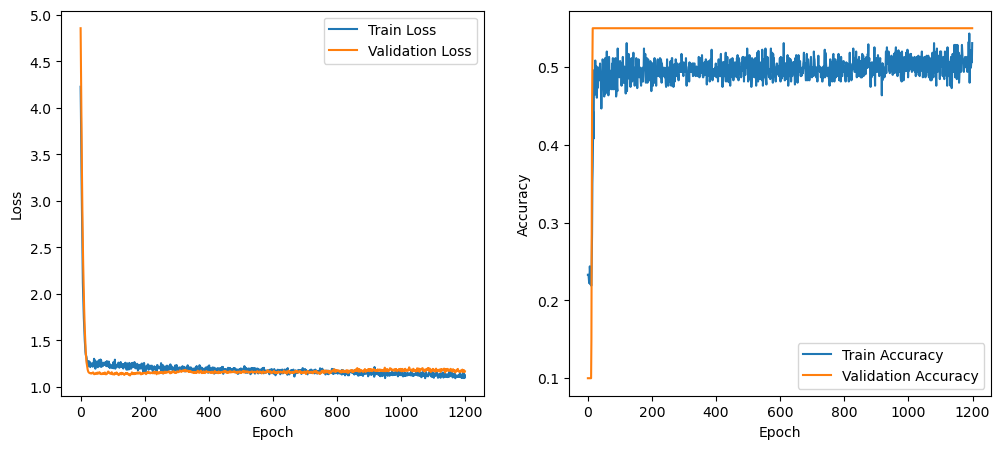

In [7]:
# Defining the model, optimizer and loss function
lr=0.00001
hidden_channels=32
num_layers=3
dropout=0.2
parameters = [lr, hidden_channels, num_layers, dropout]

model = GCN(in_channels=in_channels, hidden_channels=parameters[1], out_channels=nbr_classes, num_layers=parameters[2], dropout=parameters[3], nbr_classes=nbr_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=parameters[0])
criterion = torch.nn.CrossEntropyLoss()

# Printing the model architecture
print(model)

# Running the training
train_losses, train_accuracies, valid_losses, valid_accuracies = train(model, optimizer, criterion, train_loader, valid_loader, parameters, n_epochs=1200)

In [8]:
# Doing some parameter gridsearch to find the best hyperparameters
from sklearn.model_selection import ParameterGrid

MP = True

# param_grid = {
#     'learning_rate': [0.01, 0.001, 0.0001, 0.00001],
#     'hidden_channels': [128, 64, 32],
#     'num_layers': [3, 2, 1],
#     'dropout_rate': [0.3, 0.2, 0.1, 0.0]
# }
param_grid = {
    'learning_rate': [0.00001, 0.0001, 0.001, 0.01],
    'hidden_channels': [32, 64, 128],
    'num_layers': [1, 2, 3],
    'dropout_rate': [0.0, 0.1, 0.2, 0.3]
}

# Create combinations of hyperparameters
param_combinations = ParameterGrid(param_grid)
n_epochs = 800
# Train using each combination
for params in param_combinations:
    if MP:
        filename = f'GCN_Models_MP/lr{params["learning_rate"]}_hc{params["hidden_channels"]}_nl{params["num_layers"]}_d{params["dropout_rate"]}_epochs{n_epochs}.png'
    else:
        filename = f'GCN_Models/lr{params["learning_rate"]}_hc{params["hidden_channels"]}_nl{params["num_layers"]}_d{params["dropout_rate"]}_epochs{n_epochs}.png'
    if os.path.exists(filename):
        pass
    else:
        parameters = [params['learning_rate'], params['hidden_channels'], params['num_layers'], params['dropout_rate']]
        model = GCN(in_channels=in_channels, hidden_channels=parameters[1], out_channels=nbr_classes, num_layers=parameters[2], dropout=parameters[3], nbr_classes=nbr_classes)
        optimizer = torch.optim.Adam(model.parameters(), lr=parameters[0])
        criterion = torch.nn.CrossEntropyLoss()
        train_losses, train_accuracies, valid_losses, valid_accuracies = train(model, optimizer, criterion, train_loader, valid_loader, parameters, n_epochs=800)

Train Accuracy,▁▆▆▇▇▆▇▇▆▇▇▆▆▇▆▇▇▇▇▇▇▆▆▇▇▇▆▇▆▆▇▇▇▇▇▇▇▅██
Train Loss,█▅▅▄▄▅▃▄▃▃▃▃▃▃▃▃▃▃▃▃▂▃▃▃▂▂▃▂▂▂▂▂▂▁▁▂▂▂▂▁
Validation Accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Loss,█▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▁▂▂▁▂▂▁▂▂▂▁▃▂▂▂▂▂▂▂▂▂▂▂
Train Accuracy,0.53086
Train Loss,1.10212
Validation Accuracy,0.55
Validation Loss,1.16543


Epoch 1/800
Train Loss: 12.0921, Validation Loss: 10.0877
Train Accuracy: 0.1914, Validation Accuracy: 0.2500
Epoch 2/800
Train Loss: 11.3433, Validation Loss: 9.4041
Train Accuracy: 0.1860, Validation Accuracy: 0.2000
Epoch 3/800
Train Loss: 10.4852, Validation Loss: 8.7266
Train Accuracy: 0.1651, Validation Accuracy: 0.2000
Epoch 4/800
Train Loss: 9.8764, Validation Loss: 8.0514
Train Accuracy: 0.1721, Validation Accuracy: 0.2000
Epoch 5/800
Train Loss: 8.9617, Validation Loss: 7.3641
Train Accuracy: 0.1759, Validation Accuracy: 0.2000
Epoch 6/800
Train Loss: 8.4045, Validation Loss: 6.6915
Train Accuracy: 0.2091, Validation Accuracy: 0.1500
Epoch 7/800
Train Loss: 7.7858, Validation Loss: 6.0939
Train Accuracy: 0.1983, Validation Accuracy: 0.2000
Epoch 8/800
Train Loss: 7.2056, Validation Loss: 5.5591
Train Accuracy: 0.2037, Validation Accuracy: 0.3000
Epoch 9/800
Train Loss: 6.5158, Validation Loss: 5.0178
Train Accuracy: 0.2052, Validation Accuracy: 0.3500
Epoch 10/800
Train Loss:

KeyboardInterrupt: 

wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wand